In [1]:
import time
import pickle
import math
import pandas as pd
import numpy as np
import scipy.sparse
from sklearn import preprocessing

In [2]:
SUBMISSION = False
SUBMISSION_FILENAME = 'submission.csv'
TEST_FILENAME = 'test.csv'

In [3]:
target_playlists = pd.read_csv('../datasets/target_playlists.csv', sep='\t')
target_tracks = pd.read_csv('../datasets/target_tracks.csv', sep='\t')
tracks_final = pd.read_csv('../datasets/tracks_final.csv', sep='\t')
playlists_final = pd.read_csv('../datasets/playlists_final.csv', sep='\t')
train_final = pd.read_csv('../datasets/train_final.csv', sep='\t')

print('Successfully read data')

Successfully read data


In [4]:
def check_matrix(X, format='csc', dtype=np.float32):
    if format == 'csc' and not isinstance(X, scipy.sparse.csc_matrix):
        return X.tocsc().astype(dtype)
    elif format == 'csr' and not isinstance(X, scipy.sparse.csr_matrix):
        return X.tocsr().astype(dtype)
    elif format == 'coo' and not isinstance(X, scipy.sparse.coo_matrix):
        return X.tocoo().astype(dtype)
    elif format == 'dok' and not isinstance(X, scipy.sparse.dok_matrix):
        return X.todok().astype(dtype)
    elif format == 'bsr' and not isinstance(X, scipy.sparse.bsr_matrix):
        return X.tobsr().astype(dtype)
    elif format == 'dia' and not isinstance(X, scipy.sparse.dia_matrix):
        return X.todia().astype(dtype)
    elif format == 'lil' and not isinstance(X, scipy.sparse.lil_matrix):
        return X.tolil().astype(dtype)
    else:
        return X.astype(dtype)

In [5]:
def is_relevant(recommendation_item, validation_set):
    validation_item = validation_set.loc[validation_set['playlist_id'] == recommendation_item['playlist_id']]
    recommendation_item['recommendation'] = pd.Series(recommendation_item['recommendation'])\
                                                .isin(list(validation_item['track_id']))
    return recommendation_item


def precision(recommended_items_relevance):
    precision_scores = recommended_items_relevance.sum(axis=1) / recommended_items_relevance.shape[1]
    return precision_scores.mean()


def mAP(recommended_items_relevance):
    p_at_k = recommended_items_relevance.cumsum(axis=1) / (1 + np.arange(recommended_items_relevance.shape[1]))
    recommended_items_mAP = p_at_k.sum(axis=1) / recommended_items_relevance.shape[1]
    return recommended_items_mAP.mean()


def evaluate_recommendations(recommended_items, validation_set):
    items_relevance = recommended_items.apply(lambda recommendation_item: is_relevant(recommendation_item, validation_set), axis=1)
    recommended_items_relevance = pd.DataFrame(list(items_relevance['recommendation']), index=items_relevance['recommendation'].index)
    precision_score = precision(recommended_items_relevance)
    mAP_score = mAP(recommended_items_relevance)
    return precision_score, mAP_score

def evaluate(recommended_items, validation_set):
    print('Evaluating...')
    begin = time.time()
    precision_score, mAP_score = evaluate_recommendations(recommended_items, validation_set)
    print('Precision: {0:.{digits}f}, mAP: {1:.{digits}f}, took {2:.{digits}f}s'
          .format(precision_score, mAP_score, time.time() - begin, digits=5))

In [6]:
def str_tags_to_list(str_tags):
    if str_tags == '[]':
        return []
    return list(map(int, str_tags.replace('[', '').replace(']', '').replace(' ', '').split(',')))


def str_album_to_int(album):
    if album == '[]' or album == '[None]':
        return -1
    return int(album.replace('[', '').replace(']', ''))

In [7]:
def get_weight(i):
    if i == 0:
        return 2.5
    if i == 1:
        return 2.0
    if i == 2:
        return 1.6
    if i == 3:
        return 1.2
    if i == 4:
        return 1.0

def get_tracks_tags(track_final):
    track_tags_list = str_tags_to_list(track_final['tags'])
    return [[track_final['track_id'], track_tag, get_weight(i)] for i, track_tag in enumerate(track_tags_list)]

tracks_tags = pd.concat([pd.DataFrame(data=get_tracks_tags(track_final), columns=['track_id', 'tag', 'weight']) for index, track_final in tracks_final.iterrows()])
print('tracks_tags {}'.format(tracks_tags.shape))
print(tracks_tags.head(6))

tracks_tags (483501, 3)
  track_id     tag  weight
0  2972914   54087     2.5
1  2972914    1757     2.0
2  2972914    1718     1.6
3  2972914  116712     1.2
4  2972914  189631     1.0
0  2750239  189631     2.5


In [8]:
def get_track_album(track_final):
    track_album = str_album_to_int(track_final['album'])
    return [[track_final['track_id'], track_album]]

tracks_albums = pd.concat([pd.DataFrame(data=get_track_album(track_final), columns=['track_id', 'album']) for index, track_final in tracks_final.iterrows()])
# Remove tracks without album
tracks_albums = tracks_albums[tracks_albums.album != -1]
print('tracks_albums {}'.format(tracks_albums.shape))
print(tracks_albums.head(6))

tracks_albums (73244, 2)
   track_id  album
0   2972914      7
0   2750239      8
0   1550729      9
0   2169950      9
0   2256817      9
0   2561768     26


In [10]:
tracks_artist = pd.DataFrame()
tracks_artist['track_id'] = tracks_final['track_id']
tracks_artist['artist_id'] = tracks_final['artist_id']
print('tracks_artist {}'.format(tracks_artist.shape))
print(tracks_artist.head(6))

tracks_artist (100000, 2)
   track_id  artist_id
0   2972914        144
1   2750239        246
2   1550729        144
3   2169950        144
4   1903709        144
5   2256817        144


In [12]:
print('Data info:')
print('Tracks with album count: {}'.format(tracks_albums['track_id'].nunique()))
print('Unique album count: {}\n'.format(tracks_albums['album'].nunique()))

print('Tracks with tags count: {}'.format(tracks_tags['track_id'].nunique()))
print('Unique tags count: {}\n'.format(tracks_tags['tag'].nunique()))

print('Tracks with artists count: {}'.format(tracks_artist['track_id'].nunique()))
print('Unique artists count: {}\n'.format(tracks_artist['artist_id'].nunique()))

print('Unique tracks count: {}'.format(tracks_final['track_id'].nunique()))
print('Unique playlist count: {}'.format(playlists_final['playlist_id'].nunique()))
print('Target tracks count: {}'.format(target_tracks['track_id'].nunique()))
print('Target playlists count: {}'.format(target_playlists['playlist_id'].nunique()))

Data info:
Tracks with album count: 73244
Unique album count: 27604

Tracks with tags count: 97211
Unique tags count: 31900

Tracks with artists count: 100000
Unique artists count: 17536

Unique tracks count: 100000
Unique playlist count: 57561
Target tracks count: 32195
Target playlists count: 10000


In [13]:
track_id_le = preprocessing.LabelEncoder()
track_id_le.fit(list(tracks_final['track_id']))
print('track_id_le classes: {}'.format(len(track_id_le.classes_)))

tags_le = preprocessing.LabelEncoder()
tags_le.fit(list(tracks_tags['tag']))
print('tags_le classes: {}'.format(len(tags_le.classes_)))

album_le = preprocessing.LabelEncoder()
album_le.fit(list(tracks_albums['album']))
print('album_le classes: {}'.format(len(album_le.classes_)))

artist_le = preprocessing.LabelEncoder()
artist_le.fit(list(tracks_artist['artist_id']))
print('artist_le classes: {}'.format(len(artist_le.classes_)))

track_id_le classes: 100000
tags_le classes: 31900
album_le classes: 27604
artist_le classes: 17536


In [14]:
tracks_tags['transformed_track_id'] = track_id_le.transform(list(tracks_tags['track_id']))
tracks_tags['transformed_tag'] = tags_le.transform(list(tracks_tags['tag']))
print(tracks_tags.head(3))

tracks_albums['transformed_track_id'] = track_id_le.transform(list(tracks_albums['track_id']))
tracks_albums['album'] = list(map(lambda x: x + len(tags_le.classes_),\
                                  album_le.transform(list(tracks_albums['album']))))
print(tracks_albums.head(3))

tracks_artist['transformed_track_id'] = track_id_le.transform(list(tracks_artist['track_id']))
tracks_artist['transformed_artist_id'] = list(map(lambda x: x + len(tags_le.classes_) + len(album_le.classes_),\
                                                  artist_le.transform(list(tracks_artist['artist_id']))))
print(tracks_artist.head(3))

  track_id    tag  weight  transformed_track_id  transformed_tag
0  2972914  54087     2.5                 77187             6683
1  2972914   1757     2.0                 77187              257
2  2972914   1718     1.6                 77187              254
   track_id  album  transformed_track_id
0   2972914  31901                 77187
0   2750239  31902                 69189
0   1550729  31903                 37833
   track_id  artist_id  transformed_track_id  transformed_artist_id
0   2972914        144                 77187                  59506
1   2750239        246                 69189                  59508
2   1550729        144                 37833                  59506


In [15]:
# Playlist and tracks that belong to them
target_playlists_and_tracks = pd.merge(target_playlists, train_final, on='playlist_id')
print('target_playlists_and_tracks {}'.format(target_playlists_and_tracks.shape))
print(target_playlists_and_tracks.head(10))

target_playlists_and_tracks (362661, 2)
   playlist_id  track_id
0     10024884   2879006
1     10024884   1532328
2     10024884   3027673
3     10024884   3236144
4     10024884   1563134
5     10024884    435345
6     10024884    353291
7     10024884    247331
8     10024884    161455
9     10024884   3338954


In [16]:
def split_training_data(train_final, target_playlists_and_tracks, random_state):
    validation_set = target_playlists_and_tracks.groupby(['playlist_id'])\
                        .apply(lambda x: x.sample(n=3, random_state=random_state))\
                        .reset_index(drop=True)
    df_concat = pd.concat([train_final, validation_set])
    training_set = df_concat.drop_duplicates(keep=False)
    return training_set, validation_set

# Split dataset - from all target playlists remove randomly 3 tracks
training_set, validation_set = split_training_data(train_final, target_playlists_and_tracks, random_state=0)
test_target_tracks = validation_set['track_id'].drop_duplicates(keep='first').to_frame()
test_target_tracks['transformed_track_id'] = track_id_le.transform(list(test_target_tracks['track_id']))
target_tracks['transformed_track_id'] = track_id_le.transform(list(target_tracks['track_id']))

print('training_set: {}'.format(training_set.shape))
print(training_set.head(5))
print('validation_set: {}'.format(validation_set.shape))
print(validation_set.head(5))
print('test_target_tracks: {}'.format(test_target_tracks.shape))
print(test_target_tracks.head(5))

training_set: (1010522, 2)
   playlist_id  track_id
0      3271849   2801526
1      5616275    727878
2     11267488   2805283
3     10103900   1515105
4      3836898   2945623
validation_set: (30000, 2)
   playlist_id  track_id
0         7614   2141817
1         7614   3833025
2         7614   3711434
3         7692   2053595
4         7692   2172361
test_target_tracks: (21958, 2)
   track_id  transformed_track_id
0   2141817                 53522
1   3833025                 97760
2   3711434                 94876
3   2053595                 51310
4   2172361                 54282


In [17]:
print('tracks_tags.shape {}'.format(tracks_tags.shape))
print('tracks_albums.shape {}'.format(tracks_albums.shape))
print('tracks_artist.shape {}'.format(tracks_artist.shape))

tracks_albums_v = np.ones(tracks_albums.shape[0])
tracks_artist_v = np.ones(tracks_artist.shape[0])
# values = np.ones(tracks_tags.shape[0] + tracks_albums.shape[0] + tracks_artist.shape[0])
values = np.append(tracks_tags['weight'], np.append(tracks_albums_v, tracks_artist_v))
print('values shape: {}, vector: {}'.format(values.shape, values))

ICM = scipy.sparse.coo_matrix((values, (list(tracks_tags['transformed_track_id']) + list(tracks_albums['transformed_track_id']) + list(tracks_artist['transformed_track_id']),\
                                        list(tracks_tags['transformed_tag']) + list(tracks_albums['album']) + list(tracks_artist['transformed_artist_id']))))
ICM = ICM.tocsr()

print(ICM.shape)
features_per_item = (ICM > 0).sum(axis=1)
items_per_feature = (ICM > 0).sum(axis=0)

print('features_per_item.shape {}'.format(features_per_item.shape))
print('items_per_feature.shape {}'.format(items_per_feature.shape))

tracks_tags.shape (483501, 5)
tracks_albums.shape (73244, 3)
tracks_artist.shape (100000, 4)
values shape: (656745,), vector: [ 2.5  2.   1.6 ...,  1.   1.   1. ]
(100000, 77040)
features_per_item.shape (100000, 1)
items_per_feature.shape (1, 77040)


In [18]:
num_tot_items = ICM.shape[0]
IDF = np.array(np.log(num_tot_items / items_per_feature))[0]
ICM_idf = ICM.copy()
# compute the number of non-zeros in each col
# NOTE: this works only if X is instance of sparse.csc_matrix
col_nnz = np.diff(check_matrix(ICM_idf, 'csc').indptr)
print(col_nnz.shape)
print(ICM_idf.shape)
print(IDF.shape)
# then normalize the values in each col
ICM_idf.data *= np.repeat(IDF, col_nnz)

(77040,)
(100000, 77040)
(77040,)


In [19]:
features_per_item = np.array(features_per_item).squeeze()
items_per_feature = np.array(items_per_feature).squeeze()

print(features_per_item.shape)
print(items_per_feature.shape)

features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

(100000,)
(77040,)


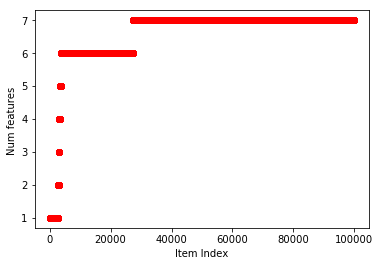

In [20]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Item Index')
pyplot.show()

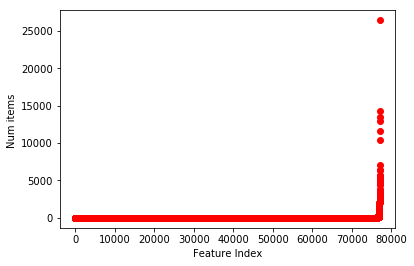

In [21]:
pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Feature Index')
pyplot.show()

In [22]:
if SUBMISSION:
    train_final['count'] = train_final.groupby(['track_id']).transform('count')
    tracks_with_popularity = train_final.groupby(['track_id', 'count']).head(1).sort_values('count', ascending=False)
    target_tracks_with_popularity = pd.merge(target_tracks, tracks_with_popularity, on='track_id').groupby('track_id').head(1)
    target_tracks_with_popularity = target_tracks_with_popularity.sort_values('count').reset_index()
    print(target_tracks_with_popularity.head(5))
else:
    training_set['count'] = training_set.groupby(['track_id']).transform('count')
    tracks_with_popularity = training_set.groupby(['track_id', 'count']).head(1).sort_values('count', ascending=False)
    target_tracks_with_popularity = pd.merge(test_target_tracks, tracks_with_popularity, on='track_id').groupby('track_id').head(1)
    target_tracks_with_popularity = target_tracks_with_popularity.sort_values('count').reset_index()
    print(target_tracks_with_popularity.head(5))

   index  track_id  transformed_track_id  playlist_id  count
0   5869   2289961                 57595     10526030      1
1  12359   2209432                 55047      1687663      1
2  18662   1881593                 46606      3835179      1
3   1586   2898917                 74939     10951086      1
4  16309   1596853                 38903      5431593      1


count    21951.000000
mean        19.728577
std         30.163626
min          1.000000
25%          4.000000
50%          9.000000
75%         22.000000
max        458.000000
Name: count, dtype: float64


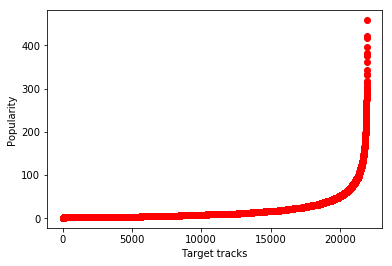

In [23]:
# target_tracks_popularity = target_tracks_with_popularity.sort_values('count').reset_index()
print(target_tracks_with_popularity['count'].describe())
pyplot.plot(target_tracks_with_popularity['count'], 'ro')
pyplot.ylabel('Popularity')
pyplot.xlabel('Target tracks')
pyplot.show()

In [24]:
class ISimilarity(object):
    """Abstract interface for the similarity metrics"""

    def __init__(self, shrinkage=10):
        self.shrinkage = shrinkage

    def compute(self, X):
        pass


class Cosine(ISimilarity):
    def compute(self, X):
        # convert to csc matrix for faster column-wise operations
        X = check_matrix(X, 'csc', dtype=np.float32)

        # 1) normalize the columns in X
        # compute the column-wise norm
        # NOTE: this is slightly inefficient. We must copy X to compute the column norms.
        # A faster solution is to  normalize the matrix inplace with a Cython function.
        Xsq = X.copy()
        Xsq.data **= 2
        norm = np.sqrt(Xsq.sum(axis=0))
        norm = np.asarray(norm).ravel()
        norm += 1e-6
        # compute the number of non-zeros in each column
        # NOTE: this works only if X is instance of sparse.csc_matrix
        
        col_nnz = np.diff(X.indptr)
        # then normalize the values in each column
        X.data /= np.repeat(norm, col_nnz)
        print("Normalized")

        # 2) compute the cosine similarity using the dot-product
        print("Computing distance")
        dist = X * X.T
        print("Computed")
    
        # and apply the shrinkage
        if self.shrinkage > 0:
            dist = self.apply_shrinkage(X, dist)
            print("Applied shrinkage")    
        
        return dist

    def apply_shrinkage(self, X, dist):
        # create an "indicator" version of X (i.e. replace values in X with ones)
        X_ind = X.copy()
        X_ind.data = np.ones_like(X_ind.data)
        # compute the co-rated counts
        co_counts = X_ind * X_ind.T
        # remove the diagonal
#         co_counts = co_counts - scipy.sparse.dia_matrix((co_counts.diagonal()[scipy.newaxis, :], [0]), shape=co_counts.shape)
        # compute the shrinkage factor as co_counts_ij / (co_counts_ij + shrinkage)
        # then multiply dist with it
        co_counts_shrink = co_counts.copy()
        co_counts_shrink.data += self.shrinkage
        co_counts.data /= co_counts_shrink.data
        dist.data *= co_counts.data
        return dist

In [25]:
distance = Cosine()
item_similarity = distance.compute(ICM)

Normalized
Computing distance
Computed


In [26]:
class ContentBasedRecommender:
    def __init__(self, to_predict=3):
        self.to_predict = to_predict
    
    def fit(self, training_set, target_tracks, items_similarity):
        self.training_set = training_set
        self.items_similarity = items_similarity
        
        self.target_tracks_mask = np.zeros(self.items_similarity.shape[0])
        for value in list(target_tracks['transformed_track_id']):
            self.target_tracks_mask[value] = 1
    
    def recommend(self, target_playlists):
        def make_recommendation(playlist):
            tracks_on_playlist = self.training_set.loc[self.training_set['playlist_id'] == playlist['playlist_id']]
            transformed_tracks_on_playlist = track_id_le.transform(list(tracks_on_playlist['track_id']))
            tracks_on_playlist_mask = np.ones(self.items_similarity.shape[0])
            for value in transformed_tracks_on_playlist:
                tracks_on_playlist_mask[value] = 0
            
            correlation = np.squeeze(np.asarray(recommender.items_similarity[:, transformed_tracks_on_playlist].mean(axis=1)))
            correlation = correlation * self.target_tracks_mask
            correlation = correlation * tracks_on_playlist_mask
            ind = np.argpartition(list(correlation), -self.to_predict)[-self.to_predict:]
            scores = np.take(correlation, ind)
        
            recommended_tracks = track_id_le.inverse_transform(ind)
            playlist['recommendation'] = list(reversed(recommended_tracks))
            playlist['scores'] = sorted(list(scores), reverse=True)
            return playlist
        recommended_items = target_playlists.apply(lambda playlist: make_recommendation(playlist), axis=1)
        return recommended_items

In [27]:
print('Building model...')
begin = time.time()
recommender = ContentBasedRecommender()
recommender.fit(training_set, test_target_tracks, item_similarity)
# recommender.fit(train_final, target_tracks, item_similarity)
print('Took {0:.{digits}f}s'.format(time.time() - begin, digits=5))

Building model...
Took 0.18721s


In [30]:
print('Recommending...')
begin = time.time()
recommended_items = recommender.recommend(target_playlists.head(1000))
print('Took {0:.{digits}f}s'.format(time.time() - begin, digits=5))

print('recommended_items {}'.format(recommended_items.shape))
print(recommended_items.head(3))

Recommending...
Took 210.42463s
recommended_items (1000, 3)
   playlist_id              recommendation  \
0     10024884   [3789197, 820484, 291014]   
1     10624787  [2790769, 3790474, 343990]   
2      4891851   [557629, 3016360, 193077]   

                                              scores  
0  [0.0148110967129, 0.00980107765645, 0.00940569...  
1  [0.019239038229, 0.0189084876329, 0.0152869420...  
2  [0.0462393686175, 0.0395016781986, 0.037847351...  


In [31]:
if not SUBMISSION:
    evaluate(recommended_items, validation_set)

Evaluating...
Precision: 0.08367, mAP: 0.09106, took 1.75589s


In [35]:
def print_results(recommended_items, filename):
    print('Printing...')
    with open('./submissions/sub{}'.format(filename), 'w') as output_file:
        output_file.write('playlist_id,track_ids\n')
        for index, recommendation in recommended_items.iterrows():
            row = '{},'.format(recommendation['playlist_id'])
            for track_id in pd.Series(recommendation['recommendation']).values:
                row += ' {}'.format(track_id)
            row += '\n'
            output_file.write(row)
print_results(recommended_items, filename=SUBMISSION_FILENAME if SUBMISSION else TEST_FILENAME)

Printing...


In [56]:
def print_validation_set(validation_set):
    print('Printing...')
    with open('./submissions/validationset.csv', 'w') as output_file:
        output_file.write('playlist_id,track_ids\n')
        for index, validation_row in validation_set.iterrows():
            if index % 3 == 0:
                playlist_id = '{},'.format(validation_row['playlist_id'])
                output_file.write(playlist_id)
            track_id = ' {}'.format(validation_row['track_id'])
            output_file.write(track_id)

            if index % 3 == 2:
                output_file.write('\n')
print_validation_set(validation_set)

Printing...
